In [9]:
## Major
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import re
import string
from tqdm import tqdm
import joblib

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
# from wordcloud import WordCloud

## sklearn -- for processing and models
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


## SMOTE for imblanced dataset
from imblearn.over_sampling import SMOTE


# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords

In [2]:
## Readind using pandas
df = pd.read_csv('testdata.manual.2009.06.14.csv', 
                 encoding='ISO-8859-1', names=['target', 'id', 'date', 'flags', 'user', 'text'])
df.head()

,target,id,date,flags,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs is good read.
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2 and I think it's perfect :)


* `EDA`

In [3]:
print('The Shape of the Dataset is: ', df.shape)

The Shape of the Dataset is:  (498, 6)


In [4]:
## Check the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  498 non-null    int64 
 1   id      498 non-null    int64 
 2   date    498 non-null    object
 3   flags   498 non-null    object
 4   user    498 non-null    object
 5   text    498 non-null    object
dtypes: int64(2), object(4)
memory usage: 23.5+ KB


In [5]:
df.dtypes

target     int64
id         int64
date      object
flags     object
user      object
text      object
dtype: object

In [6]:
df['target'].value_counts()  # 0: Negative, 2: Neutral, 4: Positive

target
4    182
0    177
2    139
Name: count, dtype: int64

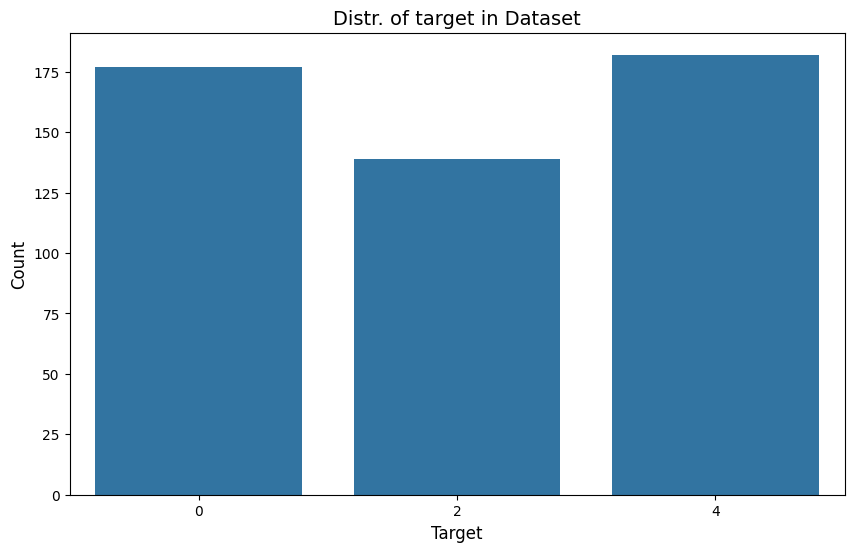

In [7]:
## countplot of target
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='target')
plt.title('Distr. of target in Dataset', fontsize=14, c='k')
plt.xlabel('Target', c='k', fontsize=12)
plt.ylabel('Count', c='k', fontsize=12)
plt.show()

In [8]:
## take a deep copy from the DF
dataset = df[['target', 'text']]
dataset

,target,text
0,4,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,Reading my kindle2... Love it... Lee childs is good read.
2,4,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
4,4,@mikefish Fair enough. But i have the Kindle2 and I think it's perfect :)
...,...,...
493,2,Ask Programming: LaTeX or InDesign?: submitted by calcio1 [link] [1 comment] http://tinyurl.com/myfmf7
494,0,"On that note, I hate Word. I hate Pages. I hate LaTeX. There, I said it. I hate LaTeX. All you TEXN3RDS can come kill me now."
495,4,Ahhh... back in a *real* text editing environment. I &lt;3 LaTeX.
496,0,"Trouble in Iran, I see. Hmm. Iran. Iran so far away. #flockofseagullsweregeopoliticallycorrect"


----

* `Text Cleaning & Viz`

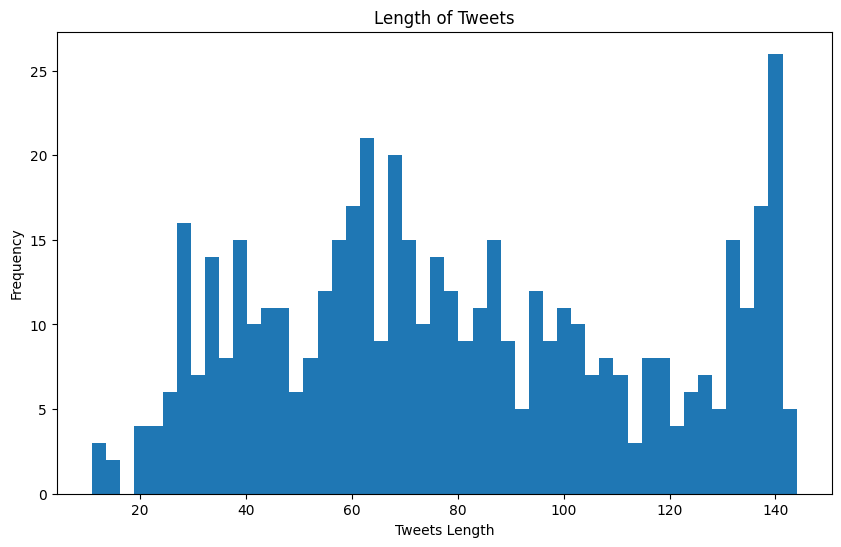

In [9]:
length_tweets = dataset['text'].str.len()
## Plotting
plt.figure(figsize=(10, 6))
plt.hist(length_tweets, bins=50)
plt.title('Length of Tweets')
plt.xlabel('Tweets Length')
plt.ylabel('Frequency')
plt.show()

In [10]:
## Hashtags
def hashtag_extract(x):
    hashtags = []
    ## Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags


# Extracting hashtags for each class
hash_neg = hashtag_extract(dataset[dataset['target']==0]['text'])  # Negative Hashtags
hash_neu = hashtag_extract(dataset[dataset['target']==2]['text'])  # Neutral Hashtags
hash_pos = hashtag_extract(dataset[dataset['target']==4]['text'])  # Positive Hashtags

# Unnesting the lists
hash_neg = sum(hash_neg, [])
hash_pos = sum(hash_pos, [])
hash_neu = sum(hash_neu, [])

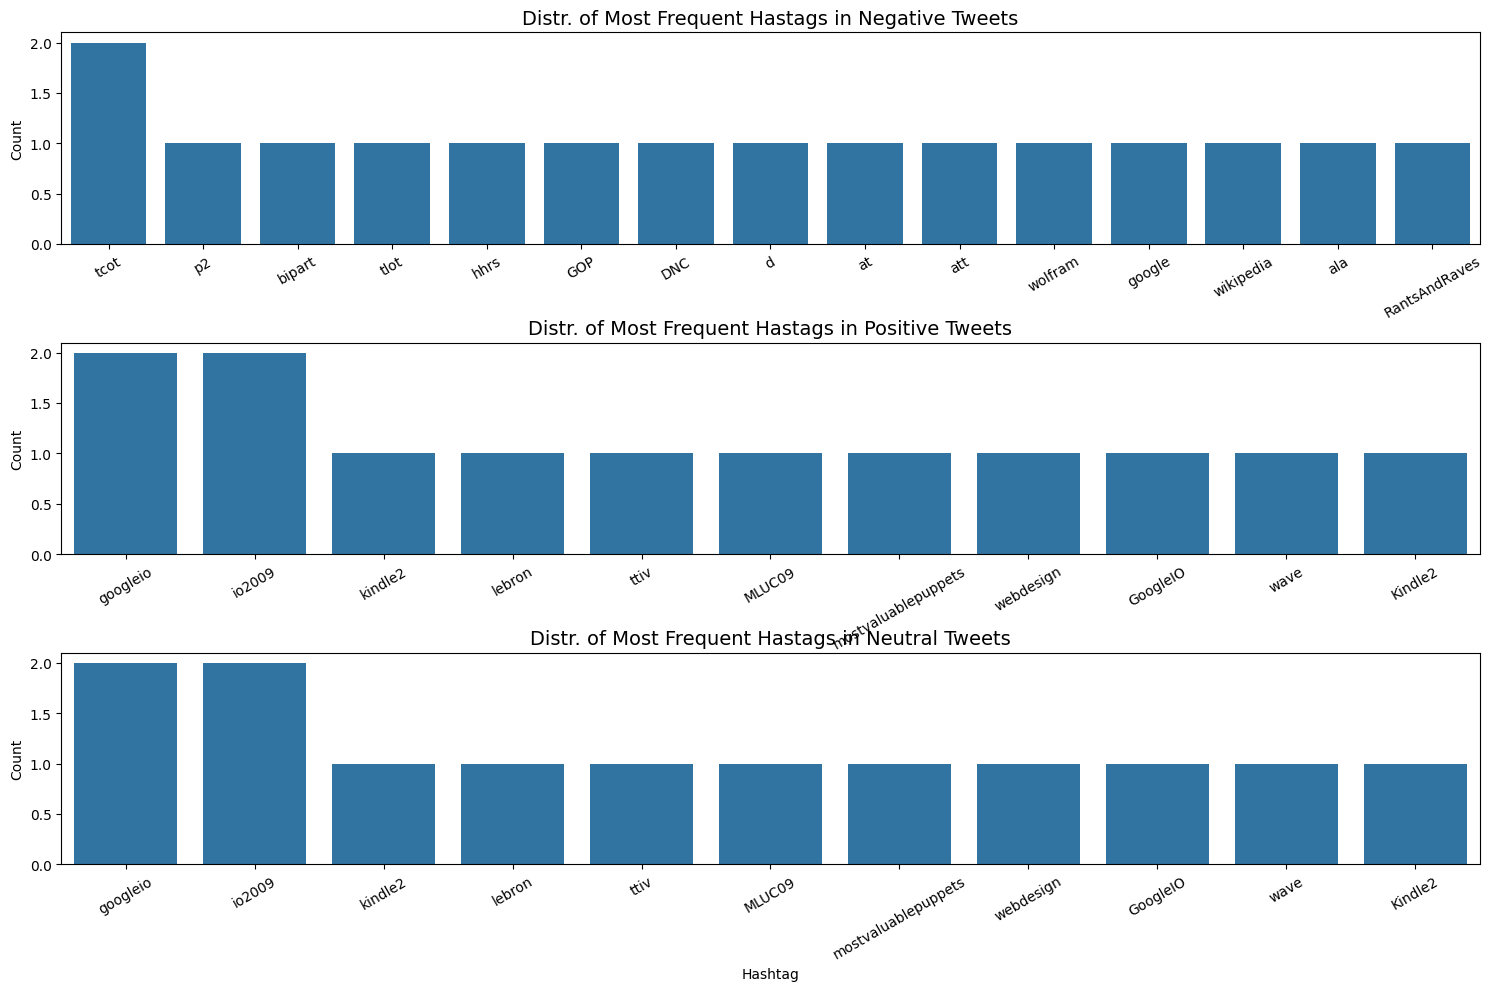

In [11]:
a_neg = nltk.FreqDist(hash_neg)
a_neu = nltk.FreqDist(hash_neu)
a_pos = nltk.FreqDist(hash_pos)

## Negative Tweets
df_neg = pd.DataFrame({'Hashtag': list(a_neg.keys()),
                  'Count': list(a_neg.values())})

## Positive Tweets
df_pos = pd.DataFrame({'Hashtag': list(a_pos.keys()),
                  'Count': list(a_pos.values())})

## Neutral Tweets
df_neu = pd.DataFrame({'Hashtag': list(a_neu.keys()),
                  'Count': list(a_neu.values())})

# selecting top 15 most frequent hashtags     
df_neg = df_neg.nlargest(columns='Count', n=15) 
df_pos = df_pos.nlargest(columns='Count', n=15) 
df_neu = df_pos.nlargest(columns='Count', n=15)


## Plotting
fig, ax = plt.subplots(3, 1, figsize=(16, 10))
fig.tight_layout(pad=5)
plt.sca(ax[0])
sns.barplot(data=df_neg, x='Hashtag', y='Count')
plt.xticks(rotation=30)
plt.title('Distr. of Most Frequent Hastags in Negative Tweets', fontsize=14, c='k')
plt.xlabel('')
##
plt.sca(ax[1])
sns.barplot(data=df_pos, x='Hashtag', y='Count')
plt.xticks(rotation=30)
plt.title('Distr. of Most Frequent Hastags in Positive Tweets', fontsize=14, c='k')
plt.xlabel('')
##
plt.sca(ax[2])
sns.barplot(data=df_neu, x='Hashtag', y='Count')
plt.xticks(rotation=30)
plt.title('Distr. of Most Frequent Hastags in Neutral Tweets', fontsize=14, c='k')
plt.show()

In [12]:
## Remove unwanted text patterns from the tweets
def remove_pattern(input_txt: str, pattern: str):
    ''' This Function takes the input and pattern you want to remove

    Args:
    *****
        (input_text: str) --> The text you want to apply the function to it.
        (pattern: str) --> The pattern you want to remove from the text.
    '''
  
    input_txt = re.sub(pattern, '', input_txt)
    return input_txt

* `Remove Tags`

In [13]:
## Removing @user in tweets, and apply the function
dataset['text'] = dataset['text'].apply(remove_pattern, pattern=r'@[\w]*')
dataset.head()

C:\Users\moham\AppData\Local\Temp\ipykernel_17576\621552815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(remove_pattern, pattern=r'@[\w]*')


,target,text
0,4,"I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,Reading my kindle2... Love it... Lee childs is good read.
2,4,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
4,4,Fair enough. But i have the Kindle2 and I think it's perfect :)


* `Remove Hyperlinks`

In [14]:
## An exmaple before removing links
dataset['text'].iloc[493]

'Ask Programming: LaTeX or InDesign?: submitted by calcio1 [link] [1 comment] http://tinyurl.com/myfmf7'

In [15]:
## Define a regular expression pattern to match URLs
## Apply the above function
dataset['text'] = dataset['text'].apply(remove_pattern, pattern=r'https?://\S+|www\.\S+')
dataset.head()

C:\Users\moham\AppData\Local\Temp\ipykernel_17576\3034942862.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(remove_pattern, pattern=r'https?://\S+|www\.\S+')


,target,text
0,4,"I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,Reading my kindle2... Love it... Lee childs is good read.
2,4,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
4,4,Fair enough. But i have the Kindle2 and I think it's perfect :)


In [16]:
## An exmaple before removing links
dataset['text'].iloc[493]

'Ask Programming: LaTeX or InDesign?: submitted by calcio1 [link] [1 comment] '

#### `Remove Repeated Characters`
* It is very challenging, There is no unique solution for this problem.
* We can remove repeated chars from words but it will affect other correct words like (happy be hapy)
* So, We can solve it bydefining a max repeat, Let's make it 2
* Note: It may produces some a few errors (But there is no better solution for that)
* These errors may be solved in stemmer or lemmatizer later

In [17]:
## An exmaple before removing repeated chars
dataset['text'].iloc[0]

' I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.'

In [18]:
## A Function to remove excessive repeated chars while preserving correct words
def remove_excessive_repeated_characters(input_string, max_repeats=2):
    ## Define a regular expression pattern to match consecutive repeated characters
    pattern = f"(\\w)\\1{{{max_repeats},}}"
    ## Replace the matched pattern with a single occurrence of the character
    cleaned_string = re.sub(pattern, r"\1", input_string)
    
    return cleaned_string

## Apply the above function
dataset['text'] = dataset['text'].apply(remove_excessive_repeated_characters)
dataset.head()

C:\Users\moham\AppData\Local\Temp\ipykernel_17576\3218407245.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(remove_excessive_repeated_characters)


,target,text
0,4,"I love my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,Reading my kindle2... Love it... Lee childs is good read.
2,4,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
4,4,Fair enough. But i have the Kindle2 and I think it's perfect :)


In [19]:
## An exmaple before removing repeated chars
dataset['text'].iloc[0]

' I love my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.'

* `Emotions Mapping`

In [20]:
## Check on sample before mapping emoticons
dataset['text'].iloc[73]

'Back when I worked for Nike we had one fav word : JUST DO IT! :)'

In [21]:
## Convert Emojis to Text : example 😀 to Happy , 😢 Sad
## This Dataset doesn't contains emojis, but it contains emotioncons like that :D, :)
## So, We can't demojize, but we will map the moticons to its meaning.

emoticon_meanings = {
    ":)": "Happy",
    ":(": "Sad",
    ":D": "Very Happy",
    ":|": "Neutral",
    ":O": "Surprised",
    "<3": "Love",
    ";)": "Wink",
    ":P": "Playful",
    ":/": "Confused",
    ":*": "Kiss",
    ":')": "Touched",
    "XD": "Laughing",
    ":3": "Cute",
    ">:(": "Angry",
    ":-O": "Shocked",
    ":|]": "Robot",
    ":>": "Sly",
    "^_^": "Happy",
    "O_o": "Confused",
    ":-|": "Straight Face",
    ":X": "Silent",
    "B-)": "Cool",
    "<(‘.'<)": "Dance",
    "(-_-)": "Bored",
    "(>_<)": "Upset",
    "(¬‿¬)": "Sarcastic",
    "(o_o)": "Surprised",
    "(o.O)": "Shocked",
    ":0": "Shocked",
    ":*(": "Crying",
    ":v": "Pac-Man",
    "(^_^)v": "Double Victory",
    ":-D": "Big Grin",
    ":-*": "Blowing a Kiss",
    ":^)": "Nosey",
    ":-((": "Very Sad",
    ":-(": "Frowning",
}


## Function to replace emoticons with their meanings
def convert_emoticons(text: str):
    ''' This Function is to replace the emoticons with thier meaning instead 
    '''
    for emoticon, meaning in emoticon_meanings.items():
        text = text.replace(emoticon, meaning)
    return text

## Apply the function on our dataset
dataset['text'] = dataset['text'].apply(convert_emoticons)
dataset.head()

C:\Users\moham\AppData\Local\Temp\ipykernel_17576\223725799.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(convert_emoticons)


,target,text
0,4,"I love my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,Reading my kindle2... Love it... Lee childs is good read.
2,4,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! Happy
4,4,Fair enough. But i have the Kindle2 and I think it's perfect Happy


In [22]:
## Check on sample before mapping emoticons
dataset['text'].iloc[73]

'Back when I worked for Nike we had one fav word : JUST DO IT! Happy'

* `Remove Punctuatiosn, Numbers, Special Chars`

In [23]:
## Removing Punctuations, Numbers, and Special Characters
dataset['text'] = dataset['text'].str.replace('[^a-zA-Z#]', ' ')
dataset.head()

C:\Users\moham\AppData\Local\Temp\ipykernel_17576\771276142.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].str.replace('[^a-zA-Z#]', ' ')


,target,text
0,4,"I love my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,Reading my kindle2... Love it... Lee childs is good read.
2,4,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! Happy
4,4,Fair enough. But i have the Kindle2 and I think it's perfect Happy


* `Removing short words`

In [24]:
## Removing Short Words
dataset['text'] = dataset['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
dataset.head()

C:\Users\moham\AppData\Local\Temp\ipykernel_17576\169024642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))


,target,text
0,4,"love Kindle2. that cool, fantastic right."
1,4,Reading kindle2... Love it... childs good read.
2,4,first assesment #kindle2 ...it fucking rocks!!!
3,4,You'll love your Kindle2. I've mine months never looked back. huge! need remorse! Happy
4,4,Fair enough. have Kindle2 think it's perfect Happy


* `Remove Numbers from Words`

In [25]:
## Call the above function (remove_pattern), We want to remove the numbers from words 
## We don't remove all numbers on the dataset, The pattern only removes the numbers within the words
dataset['text'] = np.vectorize(remove_pattern)(input_txt=dataset['text'], pattern='(?<=\w)\d+|\d+(?=\w)')
dataset.head()

C:\Users\moham\AppData\Local\Temp\ipykernel_17576\3490112379.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = np.vectorize(remove_pattern)(input_txt=dataset['text'], pattern='(?<=\w)\d+|\d+(?=\w)')


,target,text
0,4,"love Kindle. that cool, fantastic right."
1,4,Reading kindle... Love it... childs good read.
2,4,first assesment #kindle ...it fucking rocks!!!
3,4,You'll love your Kindle. I've mine months never looked back. huge! need remorse! Happy
4,4,Fair enough. have Kindle think it's perfect Happy


* `Remove Special Chars`

In [26]:
## An exmaple before removing special chars
dataset['text'].iloc[2]

'first assesment #kindle ...it fucking rocks!!!'

In [27]:
## Define a regular expression pattern to match special characters
## Apply the function to the dataset
dataset['text'] = dataset['text'].apply(remove_pattern, pattern=r'[!@#$%^&*()_+{}\[\]:;<>,.?~\\|\/]')
dataset.head()

C:\Users\moham\AppData\Local\Temp\ipykernel_17576\1286720068.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(remove_pattern, pattern=r'[!@#$%^&*()_+{}\[\]:;<>,.?~\\|\/]')


,target,text
0,4,love Kindle that cool fantastic right
1,4,Reading kindle Love it childs good read
2,4,first assesment kindle it fucking rocks
3,4,You'll love your Kindle I've mine months never looked back huge need remorse Happy
4,4,Fair enough have Kindle think it's perfect Happy


In [28]:
## An exmaple before removing special chars
dataset['text'].iloc[2]

'first assesment kindle it fucking rocks'

* `Rmeove Redundant words`

In [29]:
## An exmaple before solving that
dataset['text'].iloc[3]

"You'll love your Kindle I've mine months never looked back huge need remorse Happy"

In [30]:
## A Function to remove redundant words like (I've, You'll)
## Again, It is challenging

def remove_redundant_words_extra_spaces(text: str):
    ## Remove contractions using regular expressions
    contraction_pattern = re.compile(r"'\w+|\w+'\w+|\w+'")
    text = contraction_pattern.sub('', text)

    ## Define a set of stopwords
    stop_words = set(stopwords.words("english"))

    ## Remove stopwords and extra spaces
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    clean_text = ' '.join(filtered_words)

    ## Remove extra spaces
    clean_text = ' '.join(clean_text.split())
    
    return clean_text


## Apply the above function
dataset['text'] = dataset['text'].apply(remove_redundant_words_extra_spaces)

C:\Users\moham\AppData\Local\Temp\ipykernel_17576\1172476442.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(remove_redundant_words_extra_spaces)


In [31]:
## An exmaple before solving that
dataset['text'].iloc[3]

'love Kindle mine months never looked back huge need remorse Happy'

In [32]:
## Download the dataset here at this step before Stemming or Lemmatizing
# dataset.to_excel('dataset_1_cleaned.xlsx', index=False)

* `Tokenization`

In [33]:
## Tokenization
tokenized_tweet = dataset['text'].apply(lambda x: x.split()) 
tokenized_tweet.head()

0                                           [love, Kindle, cool, fantastic, right]
1                                      [Reading, kindle, Love, childs, good, read]
2                                       [first, assesment, kindle, fucking, rocks]
3    [love, Kindle, mine, months, never, looked, back, huge, need, remorse, Happy]
4                                    [Fair, enough, Kindle, think, perfect, Happy]
Name: text, dtype: object

In [34]:
## Lemmatization
lemmatizer = WordNetLemmatizer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [lemmatizer.lemmatize(i) for i in x]) # lemmatizer
tokenized_tweet.head()

0                                          [love, Kindle, cool, fantastic, right]
1                                      [Reading, kindle, Love, child, good, read]
2                                       [first, assesment, kindle, fucking, rock]
3    [love, Kindle, mine, month, never, looked, back, huge, need, remorse, Happy]
4                                   [Fair, enough, Kindle, think, perfect, Happy]
Name: text, dtype: object

In [35]:
## Join words again and append it to (dataset DF)
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    
dataset['text'] = tokenized_tweet
dataset.head()

C:\Users\moham\AppData\Local\Temp\ipykernel_17576\1333844843.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = tokenized_tweet


,target,text
0,4,love Kindle cool fantastic right
1,4,Reading kindle Love child good read
2,4,first assesment kindle fucking rock
3,4,love Kindle mine month never looked back huge need remorse Happy
4,4,Fair enough Kindle think perfect Happy


In [36]:
## Download the dataset after tokenizing, stemming, lemmatizing
# dataset.to_excel('dataset_1_after_tokenized.xlsx', index=False)

----

* `Some Viz`

In [37]:
' '.join(dataset[dataset['target']==4]['text'].astype(str))

'love Kindle cool fantastic right Reading kindle Love child good read first assesment kindle fucking rock love Kindle mine month never looked back huge need remorse Happy Fair enough Kindle think perfect Happy big quite happy Kindle Jquery best friend Loves twitter love Obama make joke House Correspondents dinner last night whoopi barbara amp sherri went Obama standing ovation Watchin EspnJus seen Nike Commerical Puppet Lebronsht hilariousLMAO lebron best athlete generation time basketball related want inter-sport debate 2 love lebron lebron BOSS Lebron hometown hero love Lakers Cavs lebron zydrunas awesome Lebron beast nobody come even close downloading apps iphone much literally anything good news call Visa office saying everything finewhat relief sick scam Stealing awesome come back via montreal long weekend RampR Much needed Booz Allen Hamilton homegrown social collaboration platform cool ttiv MLUC Customer Innovation Award Winner Booz Allen Hamilton current Nikon love much Canon D

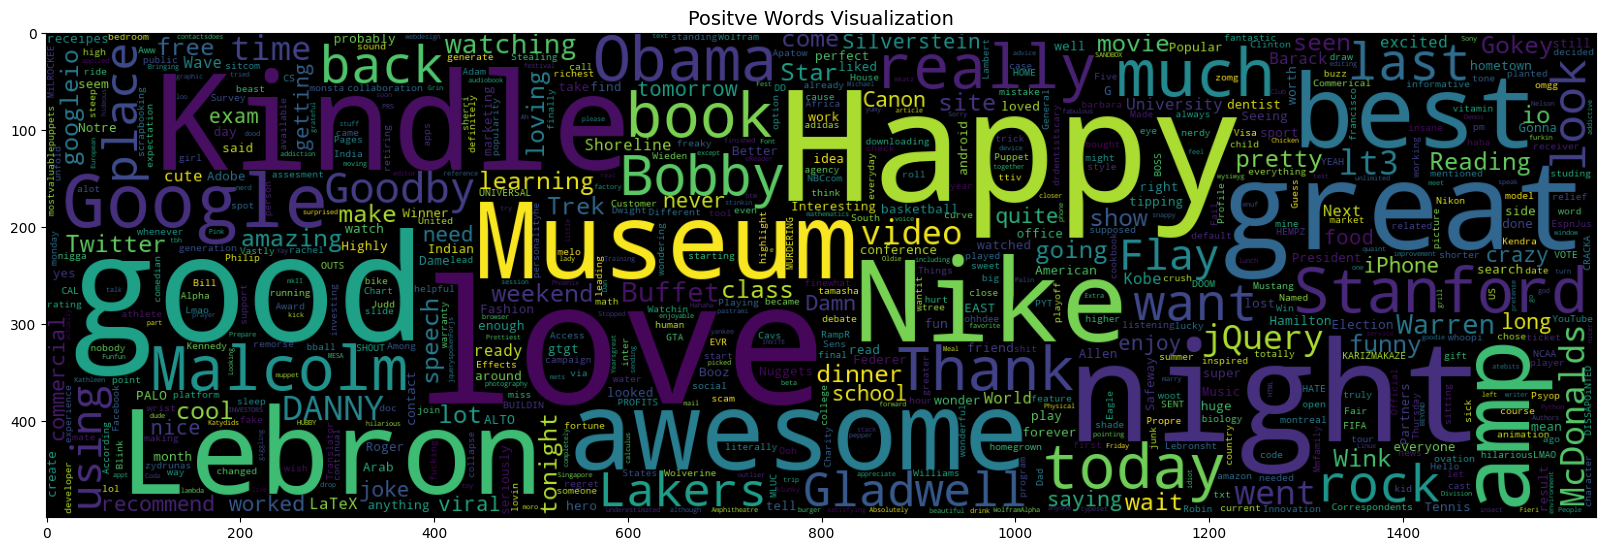

In [38]:
## For Positive Words
plt.figure(figsize=(20, 8))
wc = WordCloud(max_words=10000, width=1600, height=500, 
               collocations=False).generate(" ".join(dataset[dataset['target']==4]['text'].astype(str)))
plt.title('Positve Words Visualization', fontsize=14, c='k')
plt.imshow(wc)
plt.show()

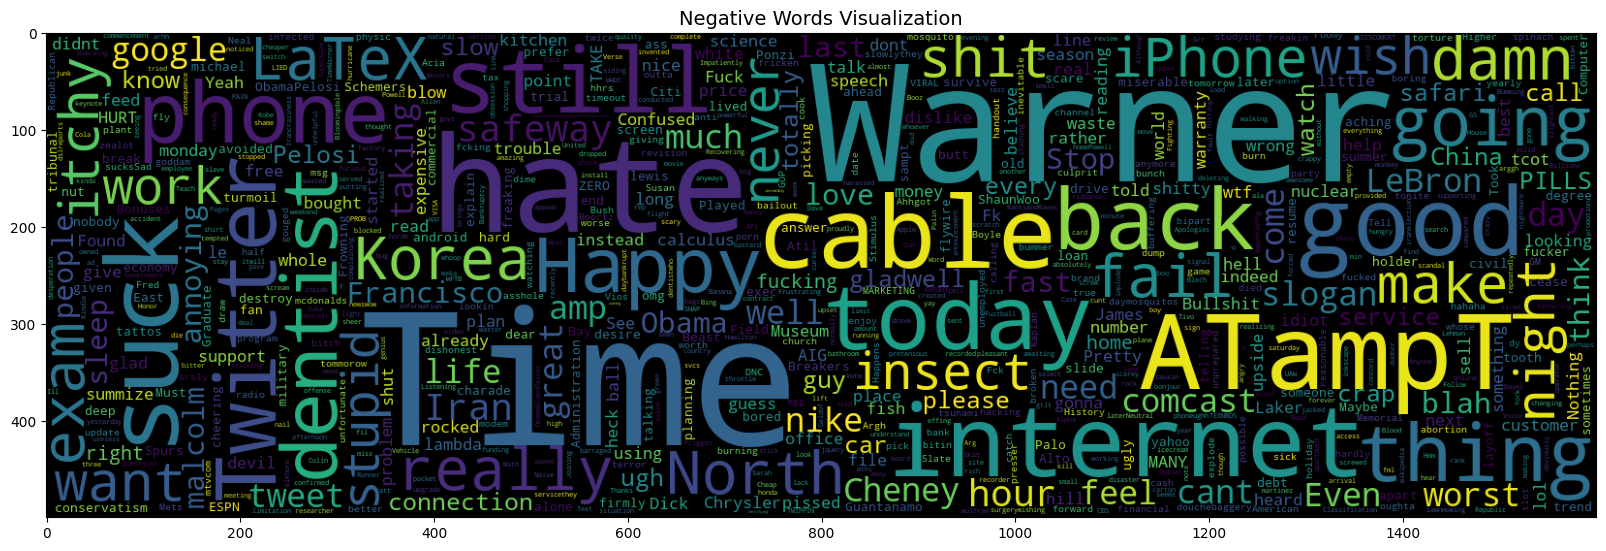

In [39]:
## For Negative Words
plt.figure(figsize=(20, 8))
wc = WordCloud(max_words=10000, width=1600, height=500, 
               collocations=False).generate(" ".join(dataset[dataset['target']==0]['text'].astype(str)))
plt.title('Negative Words Visualization', fontsize=14, c='k')
plt.imshow(wc)
plt.show()

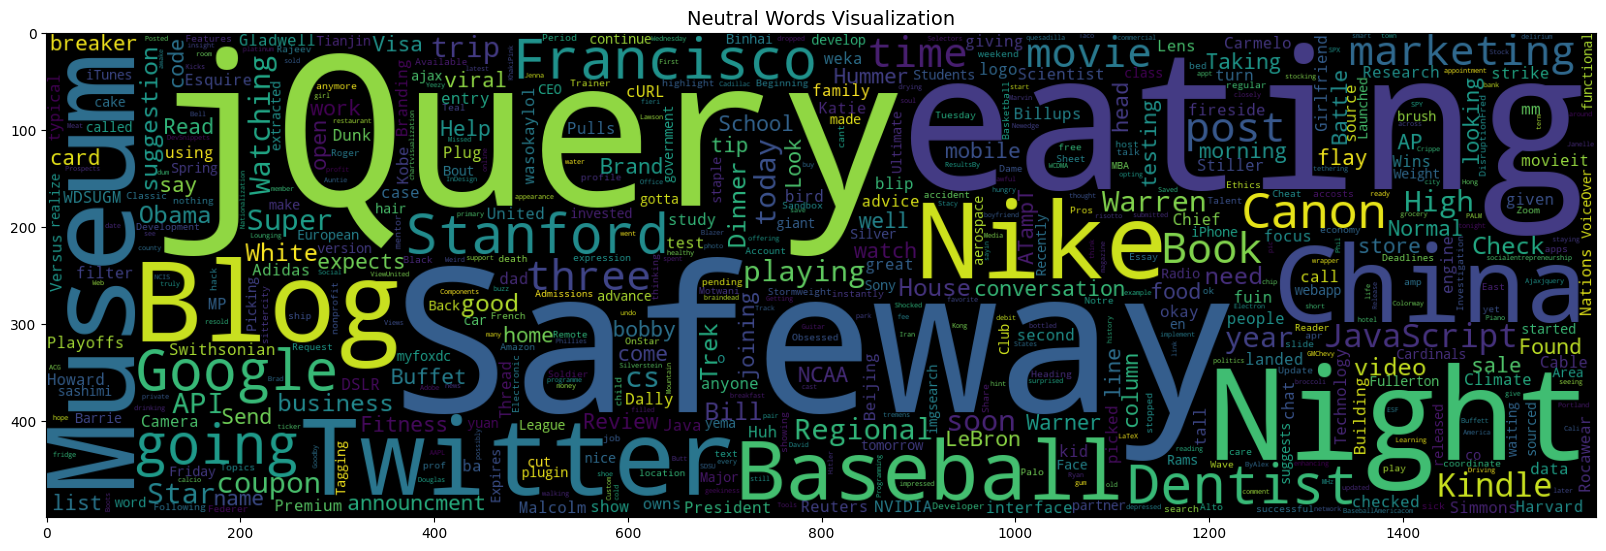

In [40]:
## For Neutral Words
plt.figure(figsize=(20, 8))
wc = WordCloud(max_words=10000, width=1600, height=500, 
               collocations=False).generate(" ".join(dataset[dataset['target']==2]['text'].astype(str)))
plt.title('Neutral Words Visualization', fontsize=14, c='k')
plt.imshow(wc)
plt.show()

* `Vectorization`

* `1. BOW`

In [41]:
## Extracting Features from Cleaned Tweets using BOW 
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=None, stop_words='english')
X_bow = bow_vectorizer.fit_transform(dataset['text'])
X_bow = X_bow.toarray()
X_bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [42]:
joblib.dump(bow_vectorizer, 'bow_vectorizer.pkl')

['bow_vectorizer.pkl']

`2. TF-IDF`

In [43]:
## Extracting Features from Cleaned Tweets using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=None, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(dataset['text'])
X_tfidf = X_tfidf.toarray()
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [44]:
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

---

* `Split The dataset`

In [45]:
## mapping --> Some Algoritms can't handle non sequential encoding
dict_map = {0: 0, 4: 1, 2: 2}    ## 0: Negative (still 0) || 4: Positive > 1 || 2: Neutral (still 2)
dict_rev_map = {v:k for k, v in dict_map.items()}

## Apply that to the dataset
dataset['target']= dataset['target'].map(dict_map)
dataset['target'].head()

C:\Users\moham\AppData\Local\Temp\ipykernel_17576\1970771037.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['target']= dataset['target'].map(dict_map)


0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [48]:
## Function to be easy in training the model
def before_models(method='BOW'):
    if method == 'bow' or method == 'BOW':
        X = X_bow
    elif method == 'tfidf' or method == 'TFIDF':
        X = X_tfidf
    else:
        print('Enter a method from (bow, tfidf)')
        
    y = dataset['target']
    
    ## Using SMOTE to solve imblanced dataset
    over = SMOTE()
    X_new, y_new = over.fit_resample(X, y)

    ## Split Datsets to train and test
    X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, 
                                                        shuffle=True, stratify=y_new, 
                                                        test_size=0.2, random_state=15)
    
    return X_train, X_test, y_train, y_test

* `Building Models`

* `SVM`

In [50]:
## Using function to apply DRY concept in an intelligent way without repearting and rewriting code 
def svm_without_jaya(method: str): 
    ''' This Function is to train MODEL using the given method and returns the train and test accuracy.
    Args:
    ****
        (method: str) --> The method of features on of (BOW, TFIDF, Word2Vec, BERT)
    
    Returns:
    *******
        (acc_train_svc: float) --> The training accuracy 
        (acc_test_svc: float) --> The test accuracy
    ''' 
    
    ## Split the Dataset first --> Call the function
    X_train, X_test, y_train, y_test = before_models(method=method)
    
    ## SVM without jaya optimizer (Using some initilaized and tuned params)
    svc = SVC(C=4, kernel='rbf', gamma=0.15, random_state=42)
    svc.fit(X_train, y_train)
    
    ## Accuracy
    y_pred_train_svc = svc.predict(X_train)
    y_pred_test_svc = svc.predict(X_test)
    
    acc_train_svc = round(100*accuracy_score(y_train, y_pred_train_svc), 4)
    acc_test_svc = round(100*accuracy_score(y_test, y_pred_test_svc), 4)
    
    ## I will return the model (In case we want it for inference in real time and deployment) with accuracies.
    return svc, acc_train_svc, acc_test_svc

In [51]:
## BOW using SVM
svc_bow, acc_train_svm_bow, acc_test_svm_bow = svm_without_jaya(method='BOW')
print(f'Accuracy Score for Training Dataset using BOW using SVM without Jaya \t {acc_train_svm_bow} %')
print(f'Accuracy Score for Testing Dataset using BOW using SVM without Jaya \t {acc_test_svm_bow} %')

Accuracy Score for Training Dataset using BOW using SVM without Jaya 	 95.4128 %
Accuracy Score for Testing Dataset using BOW using SVM without Jaya 	 72.7273 %


In [52]:
joblib.dump(svc_bow, 'svm-bow.pkl')

['svm-bow.pkl']

In [53]:
## Using TFIDF using SVM
svc_tfidf, acc_train_svm_tfidf, acc_test_svm_tfidf = svm_without_jaya(method='TFIDF')
print(f'Accuracy Score for Training Dataset using TFIDF using SVM without Jaya \t {acc_train_svm_tfidf} %')
print(f'Accuracy Score for Testing Dataset using TFIDF using SVM without Jaya \t {acc_test_svm_tfidf} %')

Accuracy Score for Training Dataset using TFIDF using SVM without Jaya 	 94.0367 %
Accuracy Score for Testing Dataset using TFIDF using SVM without Jaya 	 70.9091 %


In [54]:
joblib.dump(svc_tfidf, 'svm-tfidf.pkl')

['svm-tfidf.pkl']

In [55]:
## Combine all results of SVM wihtout Jaya in one DataFrame
acc_train_svm = [acc_train_svm_bow, acc_train_svm_tfidf]
acc_test_svm = [acc_test_svm_bow, acc_test_svm_tfidf]


## Create a DataFrame for SVM accuracies
data_svm = {
        'Method': ['SVC BOW', 'SVC TF-IDF'],
        'Train Accuracy': acc_train_svm,
        'Test Accuracy': acc_test_svm
            }

svm_accuracy_df = pd.DataFrame(data_svm)
svm_accuracy_df

,Method,Train Accuracy,Test Accuracy
0,SVC BOW,95.4128,72.7273
1,SVC TF-IDF,94.0367,70.9091


----

In [74]:
from sklearn.preprocessing import LabelEncoder
## Optimization Algorithm using Jaya Optimizer
from mealpy.swarm_based.JA import BaseJA, OriginalJA, LevyJA

In [ ]:
def svc_with_jaya(method: str):
    ''' This Function is to train SVM with Jaya optimizer. 
    Args:
    *****
        (method: str) --> The method one of (BOW, TFIDF, Word2Vec, BERT)
    '''
    
    ## Call the function --> split the dataset
    X_train, X_test, y_train, y_test = before_models(method=method)
    
    ## LABEL ENCODER (for svc kernels)
    KERNEL_ENCODER = LabelEncoder()
    KERNEL_ENCODER.fit(['linear', 'poly', 'rbf', 'sigmoid'])

    def fitness_function(solution):
        ''' This is fitness function which will be passed to Jaya Optimizer & return accuracy score
        '''
        # if kernel belongs to 0 - 0.99 ==> 0       ==> linear
        #                      1 - 1.99 ==> 1       ==> poly
        #                      2 - 2.99 ==> 2       ==> rbf
        #                      3 - 3.99 ==> 3       ==> sigmoid

        ## Choosing the kernels and Hyperparameter(C)
        kernel_encoded = int(solution[0])  ## kernel
        c = solution[1]                    ## C

        ## Just instead of text, but index
        kernel_decoded = KERNEL_ENCODER.inverse_transform([kernel_encoded])[0]  

        ## SVC Model
        svc = SVC(C=c, random_state=42, kernel=kernel_decoded)
        ## Fit the model
        svc.fit(X_train, y_train)

        ## Make the predictions
        y_pred = svc.predict(X_test)

        ## Measure the performance (accuracy)
        return accuracy_score(y_test, y_pred)
    
    
    ## Use Jaya Optimizer, Prepare Bounds
    problem = {
        "fit_func": fitness_function,
        "lb": [0, 0.01],
        "ub": [3.99, 700],
        "minmax": "max",
                }

    ## Prepare bounds and the objective function
    model = LevyJA(epoch=15, pop_size=150)
    model.solve(problem)
    print(f"Best Kernel: {KERNEL_ENCODER.inverse_transform([int(model.solution[0][0])])[0]}, \
            Best C: {model.solution[0][1]}")
    print('----'*15)
    
    ## Get the best params to train SVC on it
    best_c = model.solution[0][1]
    best_kernel = KERNEL_ENCODER.inverse_transform([int(model.solution[0][0])])[0]

    ## Finally SVC on tuned params
    svc = SVC(C=best_c, kernel=best_kernel)
    svc.fit(X_train, y_train)

    ## Accuracy
    y_pred_train = svc.predict(X_train)
    y_pred_test = svc.predict(X_test)

    acc_train = round(100*accuracy_score(y_train, y_pred_train), 4)
    acc_test = round(100*accuracy_score(y_test, y_pred_test), 4)

    print(f'Accuracy Score for Training Dataset using {method} using SVM: \t {acc_train} %')
    print(f'Accuracy Score for Tesing Dataset using {method} using SVM: \t {acc_test} %')
    print('----'*15)

    ## I will return the Model itself (In case we want to download it or use it later for Deployment) with accuracies.
    return svc, acc_train, acc_test